In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import sys

import warnings

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

from math import sin, cos, sqrt, atan2, radians

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
source_capital = r"..\data\agri\minnesota_county_location_corrected.csv"
source_station = r"..\data\weather\Minnesota Station location list.csv"

In [3]:
df_capital = pd.read_csv(filepath_or_buffer=source_capital, sep=",", header=0)
df_station = pd.read_csv(filepath_or_buffer=source_station, sep=",", header=0)

print(df_capital)
print(df_station)

               county_name   capital_name  county_latitude  county_longitude
0            Aitkin County         Aitkin        46.571482        -93.384760
1             Anoka County          Anoka        45.271020        -93.282763
2            Becker County  Detroit Lakes        46.817181        -95.845325
3          Beltrami County        Bemidji        47.478542        -94.890787
4            Benton County          Foley        45.663512        -93.913728
..                     ...            ...              ...               ...
82         Watonwan County      St. James        43.982458        -94.626918
83           Wilkin County   Breckenridge        46.265205        -96.581626
84           Winona County         Winona        43.958227        -91.780778
85           Wright County        Buffalo        45.171908        -93.874694
86  Yellow Medicine County  Granite Falls        44.809958        -95.545575

[87 rows x 4 columns]
     Code  Latitude  Longitude
0   72655   45.5466   

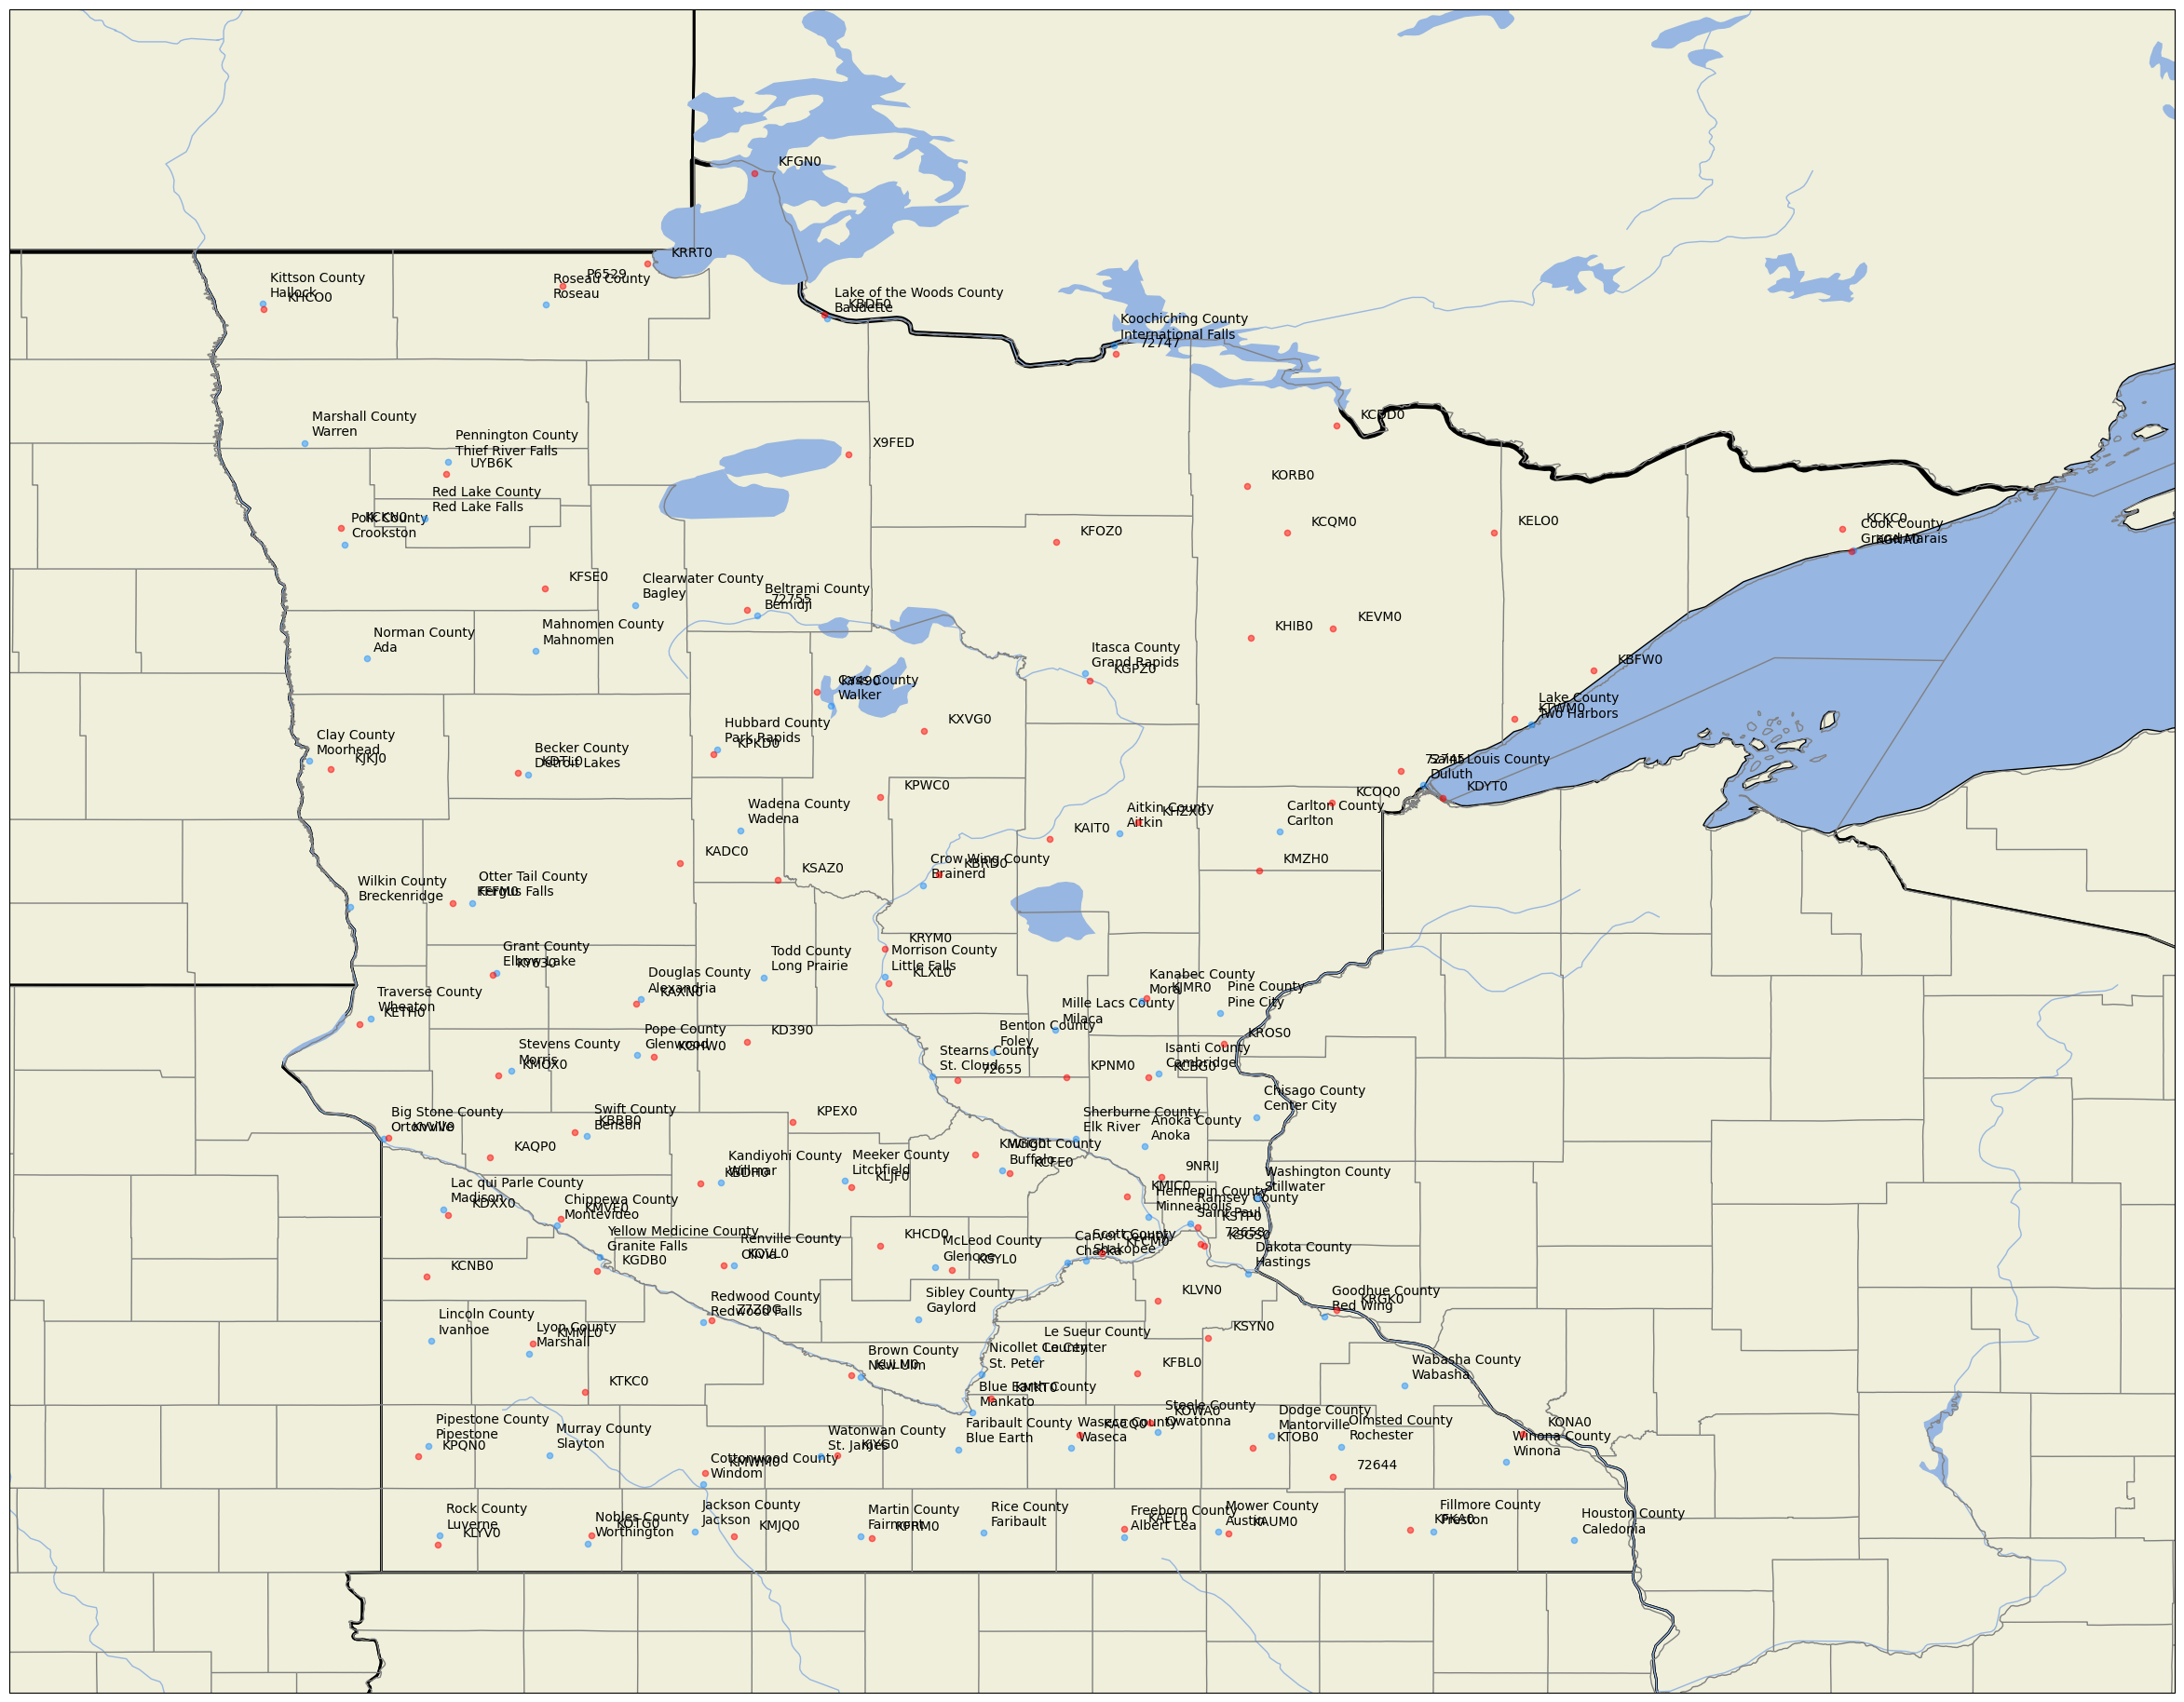

In [4]:
reader = shpreader.Reader('../data/external_data/countyl010g_shp/countyl010g.shp')

counties = list(reader.geometries())

COUNTIES = cfeature.ShapelyFeature(counties, crs.PlateCarree())
# land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
#                                         edgecolor='face',
#                                         facecolor=cfeature.COLORS['land'])


fig = plt.figure(figsize=(30, 30))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.stock_img()
ax.add_feature(cfeature.STATES, linewidth=2)
ax.add_feature(cfeature.BORDERS, linewidth=4)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')


lat1, lat2, lon1, lon2 = -98, -89, 43, 50
ax.set_extent([lat1, lat2, lon1, lon2], crs=crs.PlateCarree())

plt.scatter(y=df_capital["county_latitude"].values,
            x=df_capital["county_longitude"].values,
            color="dodgerblue",
            s=20,
            alpha=0.5,
            transform=crs.PlateCarree(),
            zorder=10) ## Important

for i, (capital, county) in enumerate(zip(df_capital["capital_name"], df_capital["county_name"])):
    ax.annotate(f"{county}\n{capital}", (df_capital["county_longitude"][i]+0.03, df_capital["county_latitude"][i]+0.03))

plt.scatter(y=df_station["Latitude"].values,
            x=df_station["Longitude"].values,
            color="red",
            s=20,
            alpha=0.5,
            transform=crs.PlateCarree(),
            zorder=10) ## Important

for i, txt in enumerate(df_station["Code"]):
    ax.annotate(txt, (df_station["Longitude"][i]+0.1, df_station["Latitude"][i]+0.03))

plt.show()

In [5]:
def get_distance_from_lat_lon_in_km(lat1:float, lon1:float, lat2:float, lon2:float) -> float:
    """Calculates the distance between two points on Earths surface in kms.

    Args:
        lat1 (float): Latitude of the first coordinate.
        lon1 (float): Longitude of the first coordinate.
        lat2 (float): Latitude of the second coordinate.
        lon2 (float): Longitude of the second coordinate.

    Returns:
        float: Distance in kms.
    """
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2 - lat1)  # deg2rad below
    dLon = radians(lon2 - lon1) 
    a = sin(dLat/2) * sin(dLat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a)) 
    d = R * c # Distance in km
    return d

def deg2rad(deg: float) -> float:
    """Returns degrees in radians

    Args:
        deg (float): Degree value.

    Returns:
        float: Radian value.
    """
    return deg * (np.pi/180)

def calculate_stations_closest_city(df_city: pd.DataFrame, df_station:pd.DataFrame) -> pd.DataFrame:
    """Calculates the clsest capital to each station, returns in a dataframe.

    Args:
        df_city (pd.DataFrame): County, capital dataframe.
        df_station (pd.DataFrame): Station dataframe.

    Returns:
        pd.DataFrame: DataFrame containing the columns Station Code,
        Capital, County, Distance, Station Lat, Station Lon,
        Capital Lat, Capital Lon
    """

    closest = {"Station Code": [],
               "Capital": [],
               "County": [],
               "Distance": [],
               "Station Lat": [],
               "Station Lon": [],
               "Capital Lat": [],
               "Capital Lon": []}

    for i in range(len(df_station.index)):
        current_station_name = df_station.iloc[i]["Code"]
        current_station_lat = df_station.iloc[i]["Latitude"]
        current_station_lon = df_station.iloc[i]["Longitude"]

        current_best = {"distance": int(1e10),
                        "capital": "kenyer",
                        "county": "dzseferzon",
                        "coords": [420, 360]}

        for j in range(len(df_city.index)):
            current_capital = df_city.iloc[j]["capital_name"]
            current_county = df_city.iloc[j]["county_name"]
            current_lat = df_city.iloc[j]["county_latitude"]
            current_lon =df_city.iloc[j]["county_longitude"]

            d = get_distance_from_lat_lon_in_km(current_station_lat, current_station_lon, current_lat, current_lon)

            if d < current_best["distance"]:
                current_best["distance"] = d
                current_best["capital"] =  current_capital
                current_best["county"] = current_county
                current_best["coords"] = [current_lat, current_lon]

        closest["Station Code"].append(current_station_name)
        closest["Distance"].append(current_best["distance"])
        closest["Capital"].append(current_best["capital"])
        closest["County"].append(current_best["county"])
        closest["Station Lat"].append(current_station_lat)
        closest["Station Lon"].append(current_station_lon)
        closest["Capital Lat"].append(current_best["coords"][0])
        closest["Capital Lon"].append(current_best["coords"][1])

    return pd.DataFrame(closest)

def get_county(lat: float, lon: float) -> str:
    """Returns the county affiliation of the given coordinate

    Args:
        lat (float): Latitude
        lon (float): Longitude

    Returns:
        str: County name
    """
    location = geolocator.reverse(f"{lat}, {lon}")
    address = location.raw['address']
    county = address.get('county', '')
    return county

def get_station_county_affiliation(df_stations: pd.DataFrame) -> pd.DataFrame:
    """_summary_

    Args:
        df_stations (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """

    proto_dataframe = {"Station": [],
                       "County": []}

    for i in range(len(df_station.index)):
        proto_dataframe["Station"].append(df_station.iloc[i]["Code"])
        proto_dataframe["County"].append(get_county(lat=df_station.iloc[i]["Latitude"], lon=df_station.iloc[i]["Longitude"]))

    return pd.DataFrame(proto_dataframe)


In [6]:
df_dist = calculate_stations_closest_city(df_city=df_capital, df_station=df_station)
df_dist.to_csv(path_or_buf="../data/intermedier/station_closest_capital.csv", index=False)
df_dist.head(10)

,Station Code,Capital,County,Distance,Station Lat,Station Lon,Capital Lat,Capital Lon
0,72655,St. Cloud,Stearns County,8.290782,45.5466,-94.0599,45.561608,-94.164200
1,72747,International Falls,Koochiching County,3.896325,48.5667,-93.4000,48.601033,-93.410590
2,72658,Saint Paul,Ramsey County,9.838701,44.8667,-93.0500,44.949749,-93.093103
3,72745,Duluth,Saint Louis County,9.677025,46.8333,-92.2167,46.772932,-92.125122
4,KAXN0,Alexandria,Douglas County,2.471302,45.8663,-95.3947,45.883510,-95.374501
5,KHIB0,Grand Rapids,Itasca County,54.696100,47.3866,-92.8390,47.237166,-93.530214
6,KSTP0,Saint Paul,Ramsey County,3.082689,44.9346,-93.0603,44.949749,-93.093103
7,KBDE0,Baudette,Lake of the Woods County,1.981877,48.7284,-94.6122,48.712441,-94.600171
8,KPKD0,Park Rapids,Hubbard County,2.629300,46.9007,-95.0731,46.922181,-95.058632
9,KCFE0,Buffalo,Wright County,2.838087,45.1592,-93.8433,45.171908,-93.874694


In [7]:
df_station_county = get_station_county_affiliation(df_stations=df_station)
df_station_county.to_csv(path_or_buf="../data/intermedier/stations_county_affiliation.csv", index=False)
df_station_county.head(10)

,Station,County
0,72655,Benton County
1,72747,Koochiching County
2,72658,Dakota County
3,72745,Saint Louis County
4,KAXN0,Douglas County
5,KHIB0,Saint Louis County
6,KSTP0,Ramsey County
7,KBDE0,Lake of the Woods County
8,KPKD0,Hubbard County
9,KCFE0,Wright County
